In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 19a8ddb2eb8>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e048>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e0a0>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e150>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e200>,
              'tobs': <sqlalc

In [11]:
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

first_day = (dt.datetime.strptime(last_day[0], '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(first_day, last_day[0])

2016-08-23 2017-08-23


Text(0, 0.5, 'Percipitation (inches)')

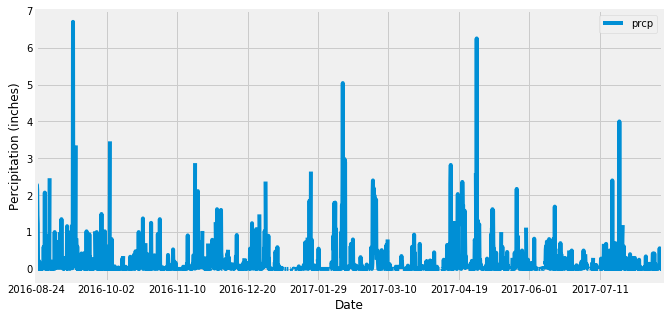

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>first_day).filter(Measurement.date<=last_day[0]).all()

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data).set_index('date')

# Sort the dataframe by date
data_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot(kind='line',figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Percipitation (inches)")

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).count()
station_count

9

In [16]:
session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter_by(station='USC00519281').all()



[(54.0, 85.0, 71.66378066378067)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


[(54.0, 85.0, 71.66378066378067)]

In [18]:
session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
temps = session.query(Measurement.tobs).\
filter(Measurement.date>first_day).filter(Measurement.date<=last_day[0]).filter_by(station='USC00519281').all()
temp_df = pd.DataFrame(temps,columns=["Temperature"])
temp_df.head()

,Temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


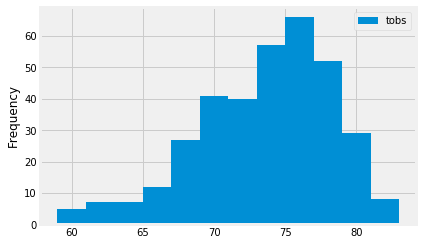

In [32]:
plt.hist(temp_df.Temperature, bins=12)
plt.ylabel("Frequency")
plt.legend(labels=["tobs"],loc='best')

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [33]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


In [40]:
(tmin,tavg,tmax) = calc_temps('2013-06-22','2013-07-02')[0]
print(tmin,tavg,tmax)


66.0 73.41333333333333 80.0


Text(0, 0.5, 'Temp (F)')

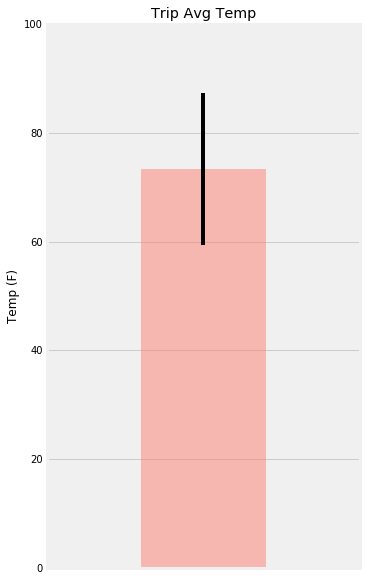

In [59]:
plt.figure(figsize=(5,10))
plt.bar(1,height=tavg,yerr=(tmax-tmin),color='salmon', alpha=0.5)
plt.xlim(0,2)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.ylabel("Temp (F)")

<IPython.core.display.Javascript object>


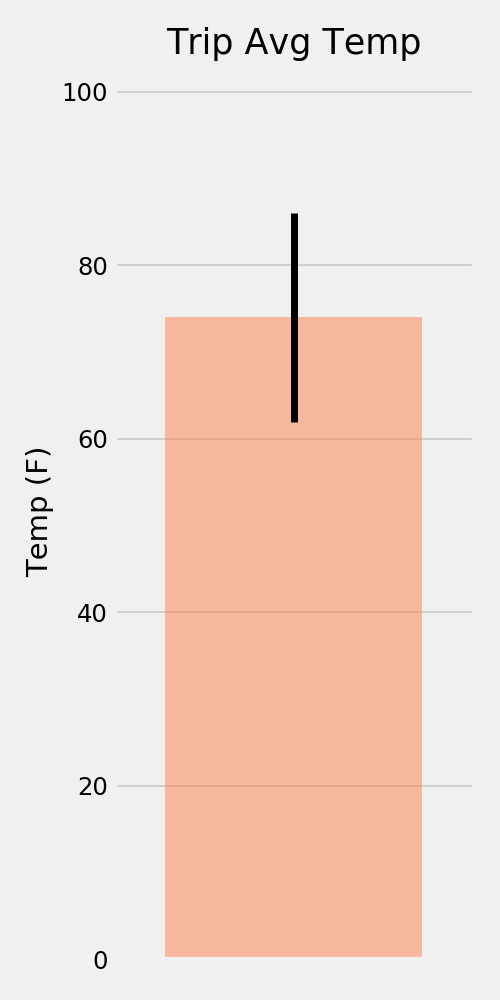

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [14]:
Station.__dict__

mappingproxy({'__table__': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 19a8de0e3b8>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e468>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e518>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e5c8>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x19a8de0e678

In [67]:
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rainfall = session.query(*sel).join(Measurement, Measurement.station==Station.station).\
    filter(Measurement.date >= '2013-06-22').filter(Measurement.date <= '2013-07-02').\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.269999999999998), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.65), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.7400000000000002), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.05), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.49), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.31000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.16), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.08)]


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [74]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [76]:
date_list = [(dt.date(2013,6,22) + dt.timedelta(days=x)) for x in range(11)]
date_list


[datetime.date(2013, 6, 22),
 datetime.date(2013, 6, 23),
 datetime.date(2013, 6, 24),
 datetime.date(2013, 6, 25),
 datetime.date(2013, 6, 26),
 datetime.date(2013, 6, 27),
 datetime.date(2013, 6, 28),
 datetime.date(2013, 6, 29),
 datetime.date(2013, 6, 30),
 datetime.date(2013, 7, 1),
 datetime.date(2013, 7, 2)]

In [78]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
date_list = [(dt.date(2013,6,22) + dt.timedelta(days=x)) for x in range(11)]
normals = [daily_normals(date.strftime('%m-%d'))[0] for date in date_list]
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals

[(69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 81.0),
 (67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [80]:
normal_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
normal_df['date'] = [date.strftime('%Y-%m-%d') for date in date_list]
normal_df = normal_df.set_index('date')
normal_df

,tmin,tavg,tmax
date,,,
2013-06-22,69.0,75.157895,81.0
2013-06-23,68.0,74.543860,80.0
2013-06-24,68.0,74.964286,84.0
2013-06-25,68.0,74.103448,80.0
2013-06-26,67.0,74.214286,82.0
2013-06-27,66.0,75.017857,81.0
2013-06-28,69.0,74.886792,80.0
2013-06-29,67.0,74.915254,80.0
2013-06-30,67.0,75.596154,81.0


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


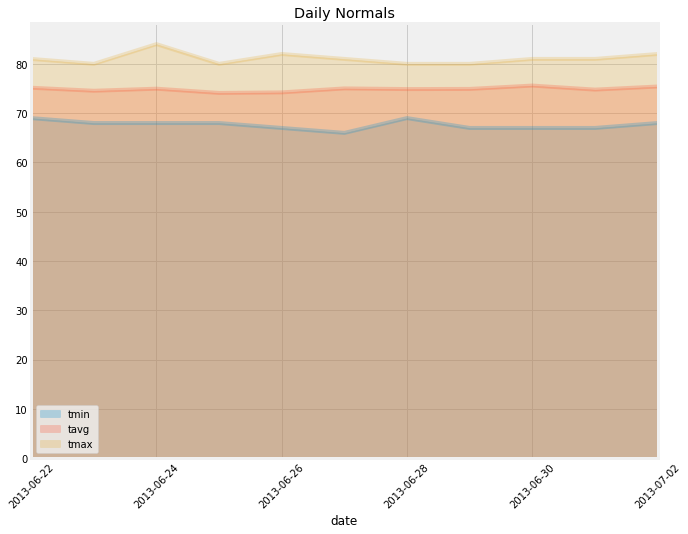

In [99]:

normal_df.plot(kind='area',alpha=0.25,stacked=False, rot=45, title="Daily Normals", figsize=(10,8))



<IPython.core.display.Javascript object>


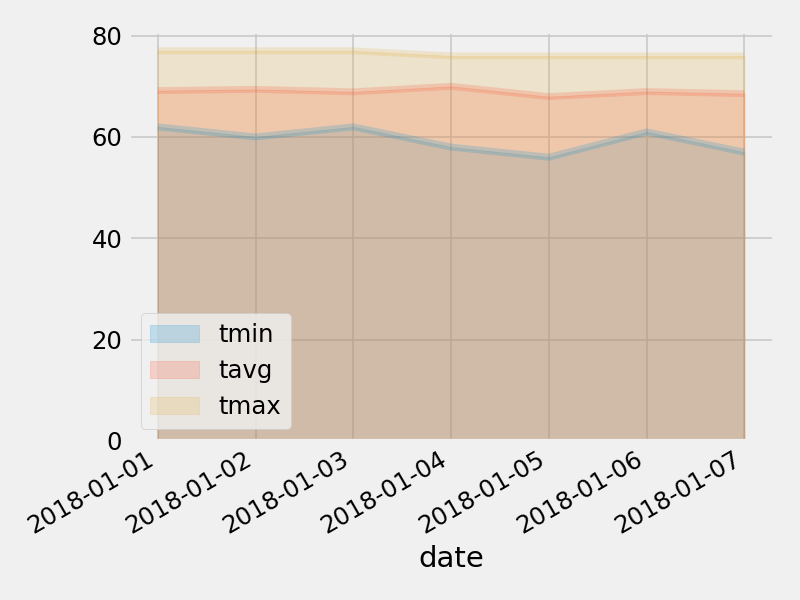

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
